In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE=128

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)


Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw




Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw




Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#Линейные слои

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(10, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.net(x)

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss() 

optim_g = torch.optim.Adam(gen.parameters(), lr=0.0001)
optim_d = torch.optim.Adam(disc.parameters(), lr=0.0001)

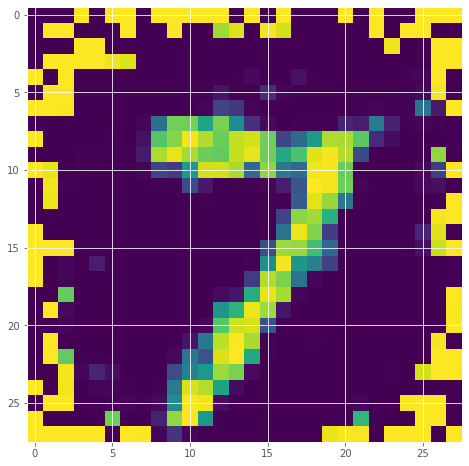

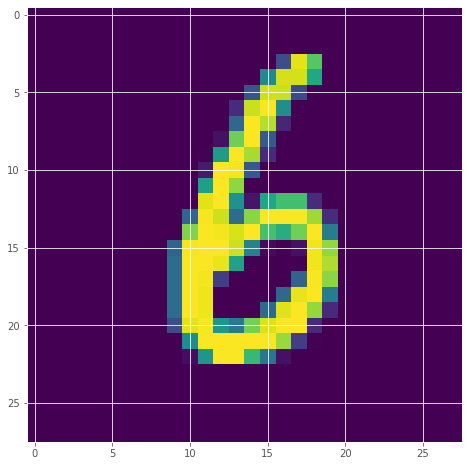

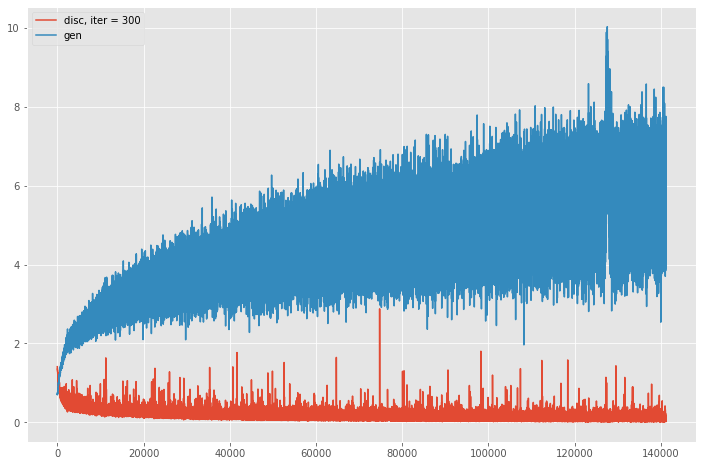

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import clear_output


z_dist = torch.distributions.Normal(torch.zeros(10), torch.ones(10))

d_losses, g_losses = [], []

for i in range(10000):
    gen.train()
    for x_real, y in train_loader:
        # update discriminator
        real_logits = disc(x_real.to(device))

        z = z_dist.sample((BATCH_SIZE,)).to(device)
        x_fake = gen(z)
        fake_logits = disc(x_fake.detach())

        d_loss = torch.nn.functional.binary_cross_entropy_with_logits(real_logits, torch.ones_like(real_logits))
        d_loss += torch.nn.functional.binary_cross_entropy_with_logits(fake_logits, torch.zeros_like(fake_logits))
        d_losses.append(d_loss)

        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # update generator
        x_fake = gen(z_dist.sample((BATCH_SIZE,)).to(device))
        fake_logits = disc(x_fake)

        g_loss = torch.nn.functional.binary_cross_entropy_with_logits(fake_logits, torch.ones_like(fake_logits))
        g_losses.append(g_loss)

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    if i % 100 == 0:
        clear_output(True)
        gen.eval()
        plt.figure(figsize=(12, 8))
        plt.imshow(gen(z_dist.sample((1,)).to(device)).reshape([28, 28]).detach().cpu())
        plt.show()
        plt.figure(figsize=(12, 8))
        plt.imshow(x_real[0].reshape([28, 28]))
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(d_losses, label=f"disc, iter = {i}")
        plt.plot(g_losses, label="gen")
        plt.legend()
        plt.show()

In [ ]:
gen.eval()
fake_imgs = gen(z_dist.sample((64,)).cuda()).detach().cpu()

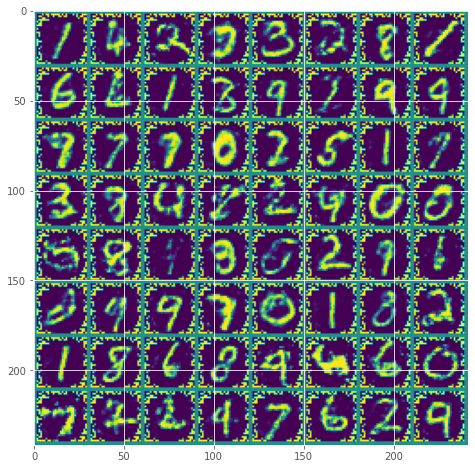

In [ ]:
import torchvision


imgs = torchvision.utils.make_grid(fake_imgs)
plt.figure(figsize=(12, 8))
plt.imshow(imgs[0])
plt.show()